## 1: SETUP PATHS

In [1]:
# CELL 1: paths (repo-root anchored)
from pathlib import Path

here = Path.cwd()
# Find the *git repository root* (never a notebooks subfolder)
REPO_ROOT = next(p for p in [here, *here.parents] if (p / ".git").is_dir())

RAW = REPO_ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

print("CWD       :", here)
print("REPO_ROOT :", REPO_ROOT)
print("RAW       :", RAW)


CWD       : C:\Users\Mihah\PyCharmProjects\data_prototype\notebooks
REPO_ROOT : C:\Users\Mihah\PyCharmProjects\data_prototype
RAW       : C:\Users\Mihah\PyCharmProjects\data_prototype\data\raw


## 2: FETCH WEATHER API DATA from METEO


In [2]:
# CELL 2: API → DataFrame
import requests
import pandas as pd

# Ljubljana, past ~48h
url = (
    "https://api.open-meteo.com/v1/forecast?"
    "latitude=46.0569&longitude=14.5058"
    "&hourly=temperature_2m,relative_humidity_2m"
    "&timezone=Europe/Ljubljana"
    "&past_days=2"
)

r = requests.get(url, timeout=30)
r.raise_for_status()
j = r.json()

df = pd.DataFrame({
    "time": j["hourly"]["time"],
    "temp_c": j["hourly"]["temperature_2m"],
    "rh": j["hourly"]["relative_humidity_2m"],
})
df["time"] = pd.to_datetime(df["time"])

print("DF shape:", df.shape)
display(df.head())


DF shape: (216, 3)


,time,temp_c,rh
0,2025-11-04 00:00:00,5.5,99
1,2025-11-04 01:00:00,5.2,98
2,2025-11-04 02:00:00,4.7,98
3,2025-11-04 03:00:00,4.0,100
4,2025-11-04 04:00:00,3.4,100


## 3: BUILD DATAFRAME

In [3]:
# CELL 3: atomic save → verify (opens only the repo-root file)
from datetime import datetime
import hashlib

out_f = RAW / "weather_lju.csv"
tmp_f = out_f.with_suffix(".csv.tmp")

# BEFORE stats
def stat_line(p: Path):
    if not p.exists():
        return "MISSING"
    s = p.stat()
    return f"size={s.st_size} bytes, mtime={datetime.fromtimestamp(s.st_mtime).isoformat(timespec='seconds')}"

print("TARGET   :", out_f.resolve())
print("BEFORE   :", stat_line(out_f))

# write atomically (Windows-safe)
with tmp_f.open("w", encoding="utf-8", newline="") as f:
    df.to_csv(f, index=False)
tmp_f.replace(out_f)

# AFTER stats
b = out_f.read_bytes()
sha = hashlib.sha256(b).hexdigest()[:12]
print("AFTER    :", stat_line(out_f))
print("SHA256   :", sha)
print("\nHEAD BYTES:\n", b[:160].decode("utf-8", errors="replace"))

# Round-trip check
df2 = pd.read_csv(out_f)
print("\nReloaded shape:", df2.shape)
display(df2.head())


TARGET   : C:\Users\Mihah\PyCharmProjects\data_prototype\data\raw\weather_lju.csv
BEFORE   : size=6181 bytes, mtime=2025-11-06T21:27:15
AFTER    : size=6181 bytes, mtime=2025-11-06T21:28:10
SHA256   : bbc66c50c601

HEAD BYTES:
 time,temp_c,rh
2025-11-04 00:00:00,5.5,99
2025-11-04 01:00:00,5.2,98
2025-11-04 02:00:00,4.7,98
2025-11-04 03:00:00,4.0,100
2025-11-04 04:00:00,3.4,100
20

Reloaded shape: (216, 3)


,time,temp_c,rh
0,2025-11-04 00:00:00,5.5,99
1,2025-11-04 01:00:00,5.2,98
2,2025-11-04 02:00:00,4.7,98
3,2025-11-04 03:00:00,4.0,100
4,2025-11-04 04:00:00,3.4,100


## 4: ATOMIC SAVE TO CSV

In [4]:
# CELL 4: ATOMIC SAVE TO CSV  (Windows-safe, newline handled)
from pathlib import Path
import hashlib

def atomic_to_csv(df, path: Path):
    tmp = path.with_suffix(path.suffix + ".tmp")
    # open the temp file yourself so you can set newline=""
    with tmp.open("w", encoding="utf-8", newline="") as f:
        df.to_csv(f, index=False)
    tmp.replace(path)  # atomic replace

out_f = RAW / "weather_lju.csv"
atomic_to_csv(df, out_f)

# Verify on disk
b = out_f.read_bytes()
sha = hashlib.sha256(b).hexdigest()[:12]

print("WROTE:", out_f.resolve())
print("SIZE:", len(b), "bytes   SHA256:", sha)
print("\nFIRST 120 BYTES:\n", b[:120].decode("utf-8", errors="replace"))


WROTE: C:\Users\Mihah\PyCharmProjects\data_prototype\data\raw\weather_lju.csv
SIZE: 6181 bytes   SHA256: bbc66c50c601

FIRST 120 BYTES:
 time,temp_c,rh
2025-11-04 00:00:00,5.5,99
2025-11-04 01:00:00,5.2,98
2025-11-04 02:00:00,4.7,98
2025-11-04 03:00:00,


## 5: VERIFY RELOAD

In [5]:
# CELL 5: VERIFY RELOAD
df2 = pd.read_csv(out_f)
print("Reloaded shape:", df2.shape)
display(df2.head())


Reloaded shape: (216, 3)


,time,temp_c,rh
0,2025-11-04 00:00:00,5.5,99
1,2025-11-04 01:00:00,5.2,98
2,2025-11-04 02:00:00,4.7,98
3,2025-11-04 03:00:00,4.0,100
4,2025-11-04 04:00:00,3.4,100


## 6. PLOT

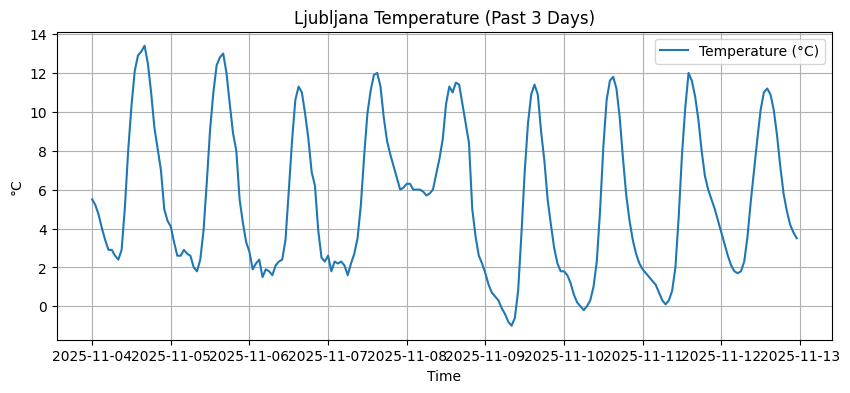

In [6]:
# CELL 6: PLOT
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df2["time"]), df2["temp_c"], label="Temperature (°C)")
plt.title("Ljubljana Temperature (Past 3 Days)")
plt.xlabel("Time")
plt.ylabel("°C")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
out_f = RAW / "weather_lju.csv"
df.to_csv(out_f, index=False)
out_f.resolve(), out_f.exists(), out_f.stat().st_size


(WindowsPath('C:/Users/Mihah/PyCharmProjects/data_prototype/data/raw/weather_lju.csv'),
 True,
 6181)

## 6. Quick plot

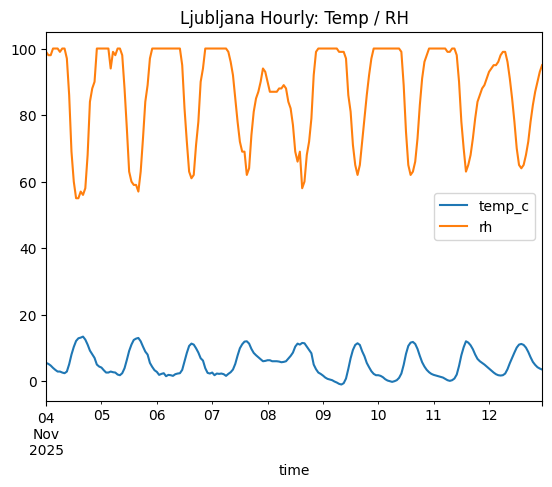

In [8]:
df.set_index("time")[["temp_c","rh"]].plot(title="Ljubljana Hourly: Temp / RH");
